# ランダマイズド・ベンチマーキング

## 目次
 
1. [導入](#intro)     
2. [ランダマイズド・ベンチマーキングのプロトコル](#protocol)     
3. [RBの直観的理解](#intuition)     
4. [同時ランダマイズド・ベンチマーキング](#simultaneousrb)     
5. [ゲートフィデリティーの予測](#predicted-gate-fidelity)    
6. [参考文献](#references)     

## 1. 導入 <a id='intro'></a>

量子情報プロセッサーを構築する上での主な課題の1つは、プロセストモグラフィーを介して発生する量子系へのノイズの完全な特徴評価はスケールできないことです。さらに、プロセストモグラフィーは、回転前および回転後のゲートノイズと測定ノイズ(SPAMエラー)に敏感です。ゲートセットトモグラフィーはこれらのエラーを考慮できますが、プロセストモグラフィーよりも更にスケールできません。完全なノイズの特徴評価ができると、適切なエラー訂正スキームの決定や、信頼できる量子情報伝送の可能性に繋がるので有用です。


大規模な系では完全なプロセストモグラフィーは不可能であるため、量子系に影響を与えるノイズを部分的に特徴づけるスケーラブルな手法への関心が高まっています。ランダム化技術を利用した単一のパラメータでクリフォードゲートのフルセットをベンチマークするための、(システムを構成する量子ビットの数$n$で）スケーラブルで強固なアルゴリズムが[1]で発表されました。量子ゲートのベンチマークにランダム化手法を用いる概念は、一般に **ランダマイズド・ベンチマーキング(RB)**と呼ばれます。


## 2. ランダマイズド・ベンチマーキングのプロトコル <a id='protocol'></a>

まず、デモのために関連するqiskitクラスをインポートします。

In [1]:
#Import general libraries (needed for functions)
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

#Import the RB Functions
import qiskit.ignis.verification.randomized_benchmarking as rb

#Import Qiskit classes 
import qiskit
from qiskit import assemble, transpile
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors.standard_errors import depolarizing_error, thermal_relaxation_error

RBプロトコル（[1,2]参照）は、以下のステップで構成されています。

### ステップ1：RB配列の生成

RB配列は、$n$量子ビット上のクリフォード群から一様に選ばれたランダムなクリフォード要素で構成されています。
これには量子ビットを初期状態に戻す反転要素を含みます。

より正確には、それぞれの長さ$m$に対して、$K_m$のRB配列を選びます。
このような配列は、それぞれ $n$量子ビット上のクリフォード群から一様に選ばれた$m$のランダム要素$C_{i_j}$を含み、$m+1$の要素は次のように定義されます。$C_{i_{m+1}} = (C_{i_1}\cdot ... \cdot C_{i_m})^{-1}$. これはGottesmann-Knillの定理で効率よく求めることができます。

例えば、2量子ビットのクリフォード回路の配列を以下に複数示します。

In [2]:
#Generate RB circuits (2Q RB)

#number of qubits
nQ = 2 
rb_opts = {}
#Number of Cliffords in the sequence
rb_opts['length_vector'] = [1, 10, 20, 50, 75, 100, 125, 150, 175, 200]
#Number of seeds (random sequences)
rb_opts['nseeds'] = 5
#Default pattern
rb_opts['rb_pattern'] = [[0, 1]]

rb_circs, xdata = rb.randomized_benchmarking_seq(**rb_opts)

一例として、1つ目のRB配列に対応する回路を表示します。

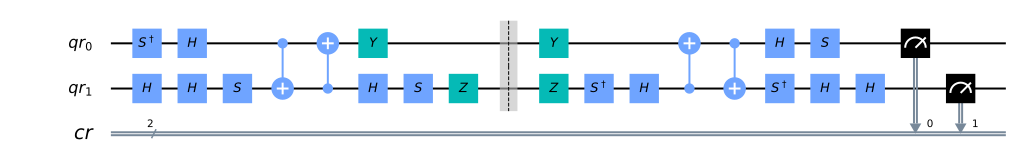

In [3]:
rb_circs[0][0].draw()

各RB回路を表すユニタリー行列が(グローバル位相を含めて)恒等変換であることを確認できます。
これをAerユニタリーシミュレータを用いて再現します。

In [4]:
# Create a new circuit without the measurement
qregs = rb_circs[0][-1].qregs
cregs = rb_circs[0][-1].cregs
qc = qiskit.QuantumCircuit(*qregs, *cregs)
for i in rb_circs[0][-1][0:-nQ]:
    qc.data.append(i)

In [5]:
# The Unitary is an identity (with a global phase)
sim = qiskit.Aer.get_backend('aer_simulator')
basis_gates = ['u1','u2','u3','cx'] # use U,CX for now
qc.save_unitary()
unitary = sim.run(qc).result().get_unitary()
from qiskit.visualization import array_to_latex
array_to_latex(unitary, prefix="\\text{Unitary} = ")

<IPython.core.display.Math object>

### ステップ2: RB配列を(ノイズを入れて)実行

RB配列は、Qiskit Aer Simulator(ノイズモデル版)かIBMQプロバイダを用いて実行し、結果のリストを得ることができます。

前提として、各演算$C_{i_j}$は、$\Lambda_{i_j,j}$で表されるエラーを持つことができ、各配列は以下の演算によってモデル化することができます。

$$\textit{S}_{\textbf{i}_\textbf{m}} = \bigcirc_{j=1}^{m+1} (\Lambda_{i_j,j} \circ C_{i_j})$$


ここで${\textbf{i}_\textbf{m}} = (i_1,...,i_m)$で、$i_{m+1}$は${\textbf{i}_\textbf{m}}$によって一意に決定されます。

In [6]:
# Run on a noisy simulator
noise_model = NoiseModel()

# Depolarizing error on the gates u2, u3 and cx (assuming the u1 is virtual-Z gate and no error)
p1Q = 0.002
p2Q = 0.01

noise_model.add_all_qubit_quantum_error(depolarizing_error(p1Q, 1), 'u2')
noise_model.add_all_qubit_quantum_error(depolarizing_error(2 * p1Q, 1), 'u3')
noise_model.add_all_qubit_quantum_error(depolarizing_error(p2Q, 2), 'cx')

backend = qiskit.Aer.get_backend('aer_simulator')

### ステップ3: 生存確率の統計を取る

各々の$K_m$配列で生存確率 $Tr[E_\psi \textit{S}_{\textbf{i}_\textbf{m}}(\rho_\psi)]$
を測定します。
ここで、$\rho_\psi$は状態生成時のエラーを考慮した初期状態であり、$E_\psi$は
測定エラーを考慮したPOVM要素です。
理想的(ノイズフリー)な場合には$\rho_\psi = E_\psi = | \psi {\rangle} {\langle} \psi |$となります。

実際には、正確な初期状態(全量子ビットが基底状態$ {|} 00...0 {\rangle}$にある状態)へ戻る確率、もしくはいずれか1つの量子ビットが基底状態に戻る確率を測定することができます。相関測定ができない場合は、独立して量子ビットを測定した方が便利です。両方の測定は、*twirl*の特性に応じて、同じ減衰パラメータでフィットされます。

### Step 4: 配列のフィデリティー平均を求める

$K_m$の配列のランダムな再現度を平均して，配列の**フィデリティー**平均を求めます．


$$F_{seq}(m,|\psi{\rangle}) = Tr[E_\psi \textit{S}_{K_m}(\rho_\psi)]$$


ここで


$$\textit{S}_{K_m} = \frac{1}{K_m} \sum_{\textbf{i}_\textbf{m}} \textit{S}_{\textbf{i}_\textbf{m}}$$


は配列の平均をとる演算です。

### ステップ 5: 結果のフィッティング

様々な$m$でステップ１から４を繰り返して、配列のフィデリティー平均の結果をモデルにフィットさせます。


$$ \textit{F}_{seq}^{(0)} \big(m,{|}\psi {\rangle} \big) = A_0 \alpha^m +B_0$$


ここで、 $A_0$ と $B_0$ は、初期状態生成時のエラーと測定エラー、および
最終ゲートのエラーのエッジ効果を取り込みます。

$\alpha$は、平均エラー率$r$を決定します。これは、**クリフォード単位エラー(EPC)**　とも呼ばれ、次の関係が成り立ちます。

$$ r = 1-\alpha-\frac{1-\alpha}{2^n} = \frac{2^n-1}{2^n}(1-\alpha)$$


(ここで、$n=nQ$は量子ビット数)。

一例として、RB配列のそれぞれについて配列のフィデリティー平均を計算し、その結果を指数関数曲線に当てはめ、パラメータ$\alpha$とEPCを計算します。



In [7]:
# Create the RB fitter
backend = qiskit.Aer.get_backend('aer_simulator')
basis_gates = ['u1','u2','u3','cx'] 
shots = 200
transpiled_circs_list = []
rb_fit = rb.RBFitter(None, xdata, rb_opts['rb_pattern'])
for rb_seed, rb_circ_seed in enumerate(rb_circs):
    print(f'Compiling seed {rb_seed}')
    new_rb_circ_seed = qiskit.compiler.transpile(rb_circ_seed, basis_gates=basis_gates)
    transpiled_circs_list.append(new_rb_circ_seed)
    print(f'Simulating seed {rb_seed}')
    qobj = assemble(new_rb_circ_seed, shots=shots)
    job = backend.run(qobj,
                      noise_model=noise_model,
                      max_parallel_experiments=0)
    # Add data to the fitter
    rb_fit.add_data(job.result())
    print('After seed %d, alpha: %f, EPC: %f'%(rb_seed,rb_fit.fit[0]['params'][1], rb_fit.fit[0]['epc']))

Compiling seed 0
Simulating seed 0
After seed 0, alpha: 0.981127, EPC: 0.014155
Compiling seed 1
Simulating seed 1
After seed 1, alpha: 0.977603, EPC: 0.016798
Compiling seed 2
Simulating seed 2
After seed 2, alpha: 0.980842, EPC: 0.014369
Compiling seed 3
Simulating seed 3
After seed 3, alpha: 0.980397, EPC: 0.014702
Compiling seed 4
Simulating seed 4
After seed 4, alpha: 0.980321, EPC: 0.014759


### 追加ステップ: 結果のプロット

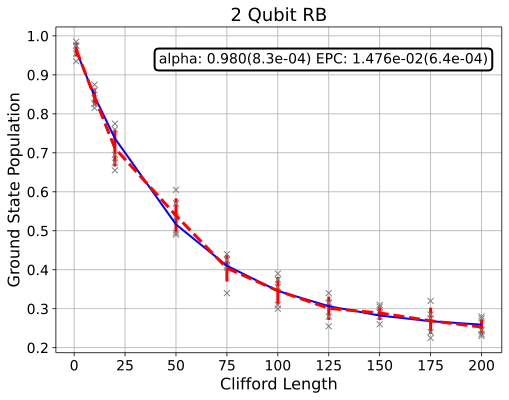

In [8]:
plt.figure(figsize=(8, 6))
ax = plt.subplot(1, 1, 1)

# Plot the essence by calling plot_rb_data
rb_fit.plot_rb_data(0, ax=ax, add_label=True, show_plt=False)
    
# Add title and label
ax.set_title('%d Qubit RB'%(nQ), fontsize=18)

plt.show()

## 3. RBの直観的理解 <a id='intuition'></a>

脱分極した量子チャンネルはパラメータ$\alpha$を持っており、次のように動作します。確率$\alpha$で状態は以前と変わらず、確率$1-\alpha$で状態は完全に混合状態になります。すなわち、



$$\rho_f = \alpha \rho_i + \frac{1-\alpha}{2^n} * \mathbf{I}$$


クリフォードゲートとは限らず、$m$ゲートの配列があるとします。ここでゲートのエラーチャンネルはパラメータ$\alpha$を持つ脱分極チャンネルです($\alpha$ は全てのゲートで共通)。このとき、確率$\alpha^m$で状態は最後の配列で正しく、確率$1-\alpha^m$で完全な混合状態になります。そのため、


$$\rho_f^m = \alpha^m \rho_i + \frac{1-\alpha^m}{2^n} * \mathbf{I}$$



今、我々は基底状態から始めることに加え以下を仮定します。
配列全体として恒等変換になるとします。
配列の最後の状態を標準基底で測定するとします。
このとき、配列の最後での成功確率は次のように求まります。



$$\alpha^m + \frac{1-\alpha^m}{2^n} = \frac{2^n-1}{2^n}\alpha^m + \frac{1}{2^n} =  A_0\alpha^m + B_0$$



成功確率、言い換えるとフィデリティーは、$\alpha$を底として配列の長さに応じ指数関数的に減衰します。

直前の主張は、チャンネルが脱分極チャネル以外の場合には必ずしも正しいと言えません。しかし、ゲートが一様にランダム化されたクリフォードゲートである場合、チャネルから計算することができるいくつかのパラメータを用いると、各ゲートのノイズは脱分極チャネルであるかのように平均的に振る舞い、フィデリティーの指数関数的な減衰を得られるということが分かります。

形式的には、量子チャネル$\bar \Lambda$の有限群$G$ (クリフォード群など)の平均をとることは、*twirl*とも呼ばれます。


$$ W_G(\bar \Lambda) \frac{1}{|G|} \sum_{u \in G} U^{\dagger} \circ  \bar \Lambda \circ U$$


ユニタリー群上をtwirlすると、クリフォード群と全く同じ結果が得られます。クリフォード群は、ユニタリー群の*2-design*です。

## 4. 同時ランダマイズド・ベンチマーキング <a id='simultaneousrb'></a>


RBは、2つの方法で多量子ビット系のフィデリティー計算に対応できるように設計されています。第一に、$n$量子ビット空間全体でのRBは、$n$量子ビットクリフォード群から配列を構築することで実行できます。第二に、$n$量子ビット空間
は$n_i$量子ビットの集合と細分化することができ、$n_i$量子ビットRBは各部分集合で同時に実行可能です[4]。
どちらの方法も、$n$量子ビット空間におけるフィデリティーの指標を与えます。

例えば、他の量子ビットが使われていなくても、CNOTゲートを定義する2量子ビットの部分集合に対して2Q RBを実行するのが一般的です。[4]で説明したように、このRBデータは、他の量子部分空間をtwirlしていないため、必ずしも指数関数的に減衰するとは限りません。すべての量子ビットが活性であるので、一定レベルのクロストークエラーも測定する同時RBによって部分空間はより厳密に特徴づけられます。

同時RBの例(1量子RBと2量子RB)は以下にあります。  
https://github.com/Qiskit/qiskit-tutorials/blob/master/tutorials/noise/4_randomized_benchmarking.ipynb

## 5. ゲートフィデリティーの予測 <a id='predicted-gate-fidelity'></a>

使用されているゲート(ゲートセット)のエラーがわかれば、RB実験を行わなくてもEPCを予測することができます。この計算は、RB実験に続いてフィッティングを行うと正しいEPC値が得られることを確認するものです。まず、クリフォードあたりのゲートの数を数える必要があります。


まず、2量子ビットのクリフォードゲートエラー関数 ``calculate_2q_epc`` が、2量子クリフォードあたりのエラーを与えます。この関数は、使用されているゲートのエラーが脱分極していることを前提としています。そしてこの関数は[5]の補足部分で導出されています。

In [9]:
# count the number of single and 2Q gates in the 2Q Cliffords
qubits = rb_opts['rb_pattern'][0]

gate_per_cliff = rb.rb_utils.gates_per_clifford(
    transpiled_circuits_list=transpiled_circs_list,
    clifford_lengths=xdata[0],
    basis=basis_gates,
    qubits=qubits)

for basis_gate in basis_gates:
    print("Number of %s gates per Clifford: %f"%(
        basis_gate,
        np.mean([gate_per_cliff[qubit][basis_gate] for qubit in qubits])))

Number of u1 gates per Clifford: 0.254694
Number of u2 gates per Clifford: 1.282751
Number of u3 gates per Clifford: 0.180022
Number of cx gates per Clifford: 1.498253


In [10]:
# convert from depolarizing error to epg (1Q)
epg_q0 = {'u1': 0, 'u2': p1Q/2, 'u3': 2 * p1Q/2}
epg_q1 = {'u1': 0, 'u2': p1Q/2, 'u3': 2 * p1Q/2}

# convert from depolarizing error to epg (2Q)
epg_q01 = 3/4 * p2Q

# calculate the predicted epc from underlying gate errors 
pred_epc = rb.rb_utils.calculate_2q_epc(
    gate_per_cliff=gate_per_cliff,
    epg_2q=epg_q01,
    qubit_pair=qubits,
    list_epgs_1q=[epg_q0, epg_q1])

print("Predicted 2Q Error per Clifford: %e (qasm simulator result: %e)" % (pred_epc, rb_fit.fit[0]['epc']))

Predicted 2Q Error per Clifford: 1.508622e-02 (qasm simulator result: 1.475925e-02)


一方、実験で得られたEPCから、使われたゲート(ゲートセット)のエラーを計算することができる。RB配列に含まれる各単一量子ビットゲートのエラーがわかっていることから、2量子ビットRB実験のEPCから2量子ビットゲートエラーを予測することができます。


2量子ビットゲートエラー関数 ``calculate_2q_epg`` は、2量子ビットゲートあたりのエラーの推定値を与えます。ここでは、脱分極エラーモデルを用いて1量子ビットのエラーを用意します。エラーモデルが不明な場合、それらのゲートのEPG(例えば [``u1``, ``u2``, ``u3``])はユーティリティ関数 ``calculate_1q_epg``を用いて、別の1量子RB実験で推定することができます。

In [11]:
# use 2Q EPC from qasm simulator result and 1Q EPGs from depolarizing error model
pred_epg = rb.rb_utils.calculate_2q_epg(
    gate_per_cliff=gate_per_cliff,
    epc_2q=rb_fit.fit[0]['epc'],
    qubit_pair=qubits,
    list_epgs_1q=[epg_q0, epg_q1])

print("Predicted 2Q Error per gate: %e (gate error model: %e)" % (pred_epg, epg_q01))

Predicted 2Q Error per gate: 7.261899e-03 (gate error model: 7.500000e-03)


## 6. 参考文献 <a id='references'></a>

1. Easwar Magesan, J. M. Gambetta, and Joseph Emerson, *Robust randomized benchmarking of quantum processes*,
https://arxiv.org/pdf/1009.3639

2. Easwar Magesan, Jay M. Gambetta, and Joseph Emerson, *Characterizing Quantum Gates via Randomized Benchmarking*,
https://arxiv.org/pdf/1109.6887

3. A. D. C'orcoles, Jay M. Gambetta, Jerry M. Chow, John A. Smolin, Matthew Ware, J. D. Strand, B. L. T. Plourde, and M. Steffen, *Process verification of two-qubit quantum gates by randomized benchmarking*, https://arxiv.org/pdf/1210.7011

4. Jay M. Gambetta, A. D. C´orcoles, S. T. Merkel, B. R. Johnson, John A. Smolin, Jerry M. Chow,
Colm A. Ryan, Chad Rigetti, S. Poletto, Thomas A. Ohki, Mark B. Ketchen, and M. Steffen,
*Characterization of addressability by simultaneous randomized benchmarking*, https://arxiv.org/pdf/1204.6308

5. David C. McKay, Sarah Sheldon, John A. Smolin, Jerry M. Chow, and Jay M. Gambetta, *Three Qubit Randomized Benchmarking*, https://arxiv.org/pdf/1712.06550

In [12]:
import qiskit.tools.jupyter
%qiskit_version_table

{'qiskit-terra': '0.14.2',
 'qiskit-aer': '0.5.2',
 'qiskit-ignis': '0.3.3',
 'qiskit-ibmq-provider': '0.7.2',
 'qiskit-aqua': '0.7.3',
 'qiskit': '0.19.6'}